In [6]:
import scanpy as sc
import phate
import scprep
import gspa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-06-24 10:04:14.282292: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 10:04:14.284461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 10:04:14.326512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 10:04:14.327805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 10:04:15.171747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [7]:
adata = sc.datasets.pbmc3k_processed()

In [8]:
# convert clusters to more coarse cell types to use PanglaoDB markers for downstream analysis
conv = dict(zip(adata.obs['louvain'].cat.categories,
['T cells', 'Monocytes', 'B cells', 'T cells', 'NK cells', 'Monocytes', 'Dendritic cells', 'Megakaryocytes']))
adata.obs['cell_types'] = [conv[x] for x in adata.obs['louvain']]

In [9]:
phate_op = phate.PHATE(random_state=42, verbose=False)
data_phate = phate_op.fit_transform(adata.to_df())

<Axes: title={'center': 'Embedding all genes'}>

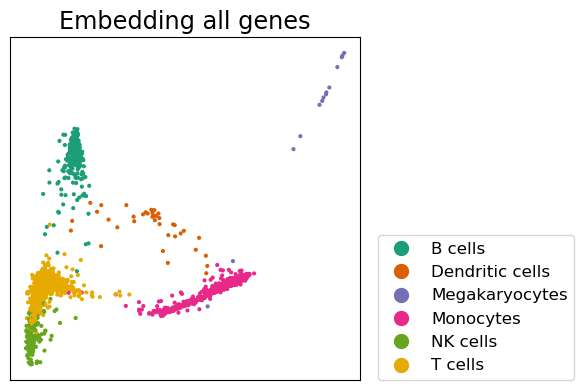

In [10]:
scprep.plot.scatter2d(data_phate, c=adata.obs['cell_types'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding all genes', filename='figures/pbmc_embedding.png', cmap='Dark2')

In [75]:
gspa_op = gspa.GSPA(graph=phate_op.graph, random_state=1234)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()
gene_signals = adata.to_df().T
gene_ae, gene_pc = gspa_op.get_gene_embeddings(gene_signals)
gene_localization = gspa_op.calculate_localization()

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 1/100
55/55 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 11/

In [76]:
np.savez('../results/pbmc_gene_embedding.npz', signal_embedding=gene_ae,
         localization_score=gene_localization, genes=adata.var_names)

## Gene embedding analysis

In [77]:
results = np.load('../results/pbmc_gene_embedding.npz', allow_pickle=True)

In [78]:
phate_op = phate.PHATE(random_state=42, verbose=False, t=40)
data_phate = phate_op.fit_transform(results['signal_embedding'])

In [79]:
all_markers = pd.read_csv('data/PanglaoDB_markers.tsv', sep='\t')
cell_types = ['T cells', 'Monocytes', 'B cells', 'NK cells', 'Dendritic cells', 'Megakaryocytes']
all_markers = all_markers[(all_markers['cell type'].isin(cell_types)) & (all_markers['canonical marker'] == 1.0)]

gene_embedding_markers = {}
for cell_type in cell_types:
    cell_type_genes = all_markers[all_markers['cell type'] == cell_type]['official gene symbol'].tolist()
    gene_embedding_markers[cell_type] = set(cell_type_genes).intersection(results['genes'])

gene_embedding_markers_loc = {}
for cell_type in cell_types:
    x = adata.to_df()[list(gene_embedding_markers[cell_type])].groupby(adata.obs['cell_types']).mean()
    gene_embedding_markers_loc[cell_type] = x.idxmax()[x.idxmax() == cell_type].index.tolist()

vis_markers = []
vis_marker_cell_type = []
for k,v in gene_embedding_markers_loc.items():
    vis_marker_cell_type.extend([k[:-1] + ' gene markers']*len(v))
    vis_markers.extend(v)
vis_markers = pd.DataFrame([vis_markers, vis_marker_cell_type]).T.set_index(0)
vis_markers = vis_markers.loc[results['genes'][pd.Series(results['genes']).isin(vis_markers.index)]]

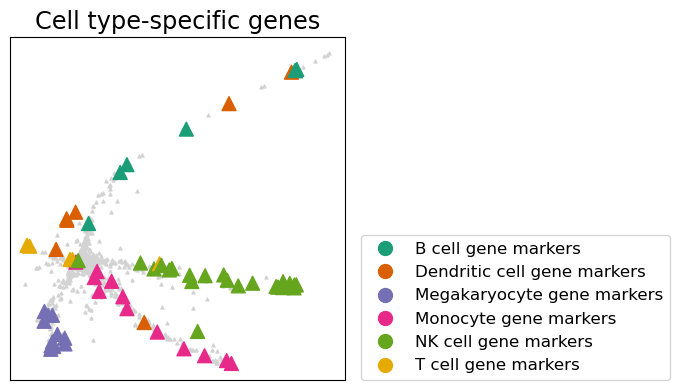

In [80]:
fig, ax = plt.subplots(figsize=(7,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
scprep.plot.scatter2d(data_phate[pd.Series(results['genes']).isin(vis_markers.index)], cmap='Dark2',
                      marker='^', c=vis_markers[1], ax=ax, s=100, legend_loc=(1.05,0), dpi=300,
                      title='Cell type-specific genes')
plt.tight_layout()
fig.savefig('figures/cell_type_specific_genes.png', dpi=300)